### Parametros tirado de Paper

1. Proporcao de assintomaticos: 2.8%

2. taxa de mortalidade: 1.39% (março-junho)

3. taxa de infeccao: 17.2% (março-junho)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.stats import norm
%matplotlib inline
plt.style.use('seaborn-darkgrid')

In [564]:
#contruimos nosso modelo f especificando o sistema de edos
def f(xs,t,ps):
    
    # Esse try é conveniente para mais tarde passar um dicionario dos parametros para
    # poder fazer o fitting do modelo aos dados com o biblioteca lmfit
    
    #para mais detalhes dos parametros olhar o .pdf dos resultados finais
    try:
        tau = ps['tau'].value
        sigma = ps['sigma'].value
        alpha = ps['alpha'].value
        lambd1 = ps['lambd1'].value
        lambd2 =ps['lambd2'].value
        mu =ps['mu'].value
        mu2 =ps['mu2'].value
        tmu = ps['tmu'].value
        delta =ps['delta'].value
        beta =ps['beta'].value
        r =ps['r'].value
        rho = ps['rho'].value
        irho = ps['irho'].value
        p = ps['p'].value
        p2 = ps['p2'].value
        tp = ps['tp'].value

    except:
        
        tau, sigma, alpha, lambd1, lambd2, mu,mu2,tmu, delta, beta, r, rho, irho, p, p2, tp= ps
        
    
    #inicializando os valores dos estados do nosso sistema
    
    St, E, Eq, I, Iq, A, Aq, Q, R, D = xs
    
    #Parametros adicionais para tornar os parametros do nosso sistema variaveis
    
    #poly = lambda x, a, b, c, d, e: e+d*x+c*x**2+b*x**3+a*x**4 if e+d*x+c*x**2+b*x**3+a*x**4 > 0 else 0
    
    
    #tau = poly(t,tau4,tau3,tau2,tau1,tau)
    #sigma = poly(t,sigma4,sigma3,sigma2,sigma1,sigma)
    #alpha = poly(t,alpha4, alpha3,alpha2, alpha1,alpha)
    
    if t > tp: p = p2
    #p = norm.pdf(t,tp,p2)
    if t > tmu: mu = mu2
    
    rho = t*rho + irho
        
    # Separando o numero de sucetiveis que estao praticando o distanciamento social dos que nao estao
    
    
    S = (1-p)*St
    Sq = p*St
    
    return [
        -beta*S*(I+A+r*(Iq+Aq))-r*beta*Sq*(I+A+r*(Iq+Aq)),
        beta*S*(I+A+r*(Iq+Aq))-rho*delta*E-tau*E,
        r*beta*Sq*(I+A+r*(Iq+Aq))-rho*delta*Eq-tau*Eq,
        tau*E-sigma*I-rho*I,
        tau*Eq-sigma*Iq-rho*Iq,
        alpha*sigma*I-rho*A-lambd1*A,
        alpha*sigma*Iq-rho*Aq-lambd1*Aq,
        sigma*(1-alpha)*(I+Iq)+rho*(delta*(E+Eq)+I+Iq+A+Aq)-lambd2*Q-mu*Q,
        lambd1*(A+Aq)+lambd2*Q,
        mu*Q
           ]

# funcao g ira tratar valores iniciais para que a soma deles somam 1 e devolve a solucao 
# numerica do nosso modelo dado tempo, condicoes inicais e parametros

def g(t, x0, ps):
    St = 1 - np.sum(x0)
    x0 = np.insert(x0,0,St)
    x = odeint(f,x0, t, args = (ps,),hmin = 0.001, hmax = 1)
    return x


def g(t, x0, ps):
    St = 1 - np.sum(x0)
    x0 = np.insert(x0,0,St)
    x = odeint(f,x0, t, args = (ps,),hmin = 0.001, hmax = 1)
    return x



#funcao residual é usada mais tarde pela biblioteca lmfit para fittar o modelo aos dados
def residual(ps, ts, data):
    x0 = ps['E'].value,ps['Eq'].value,ps['I'].value,ps['Iq'].value,ps['A'].value,ps['Aq'].value,ps['Q'].value,ps['R'].value,ps['D'].value
    model = g(ts, x0, ps)
    
    model = model[:,3]+model[:,4] #soma dos infectados praticando isomaneto social com os que nao estao
    model *= 8.3*10e6 #multiplicando pela populcao da cidade de NY
    
    return (model - data).ravel()


In [671]:
df

,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
0,1,0,0
1,0,0,0
2,0,0,0
3,1,1,0
4,5,2,0
...,...,...,...
274,1622,133,11
275,2580,152,17
276,2665,157,17
277,2087,125,22


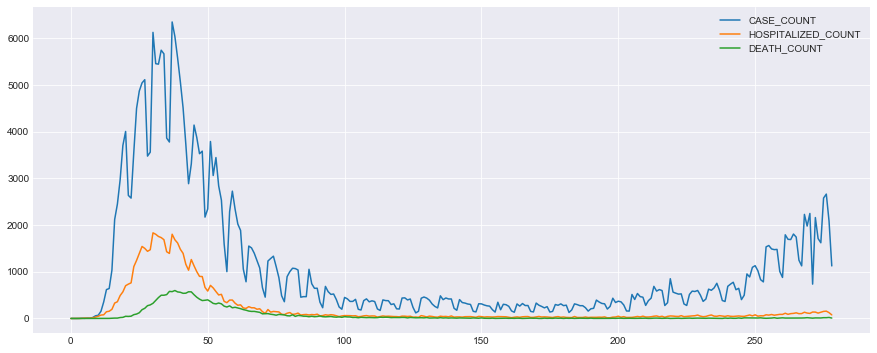

In [670]:
df = pd.read_csv("COVID-19_Daily_Counts_of_Cases__Hospitalizations__and_Deaths.csv")
df = df[['CASE_COUNT', 'HOSPITALIZED_COUNT','DEATH_COUNT']]
df.plot(figsize = (15,6))
plt.show()

In [796]:
df

,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
0,1,0,0
1,0,0,0
2,0,0,0
3,1,1,0
4,5,2,0
...,...,...,...
274,1622,133,11
275,2580,152,17
276,2665,157,17
277,2087,125,22


In [798]:
inf_dead = df.to_numpy()
inf_dead = np.array(inf_dead)
t = np.linspace(0,279,279)


In [568]:
def residual(ps, ts, data):
    x0 = ps['E'].value,ps['Eq'].value,ps['I'].value,ps['Iq'].value,ps['A'].value,ps['Aq'].value,ps['Q'].value,ps['R'].value,ps['D'].value
    model = g(ts, x0, ps)
    
    model = list(map(lambda x: [x[0]+x[1], x[2]],model[:,[3,4,9]])) #infectados e mortos
    model = np.array(model)
    #model = model[:,3]+model[:,4] #soma dos infectados praticando isomaneto social com os que nao estao
    model *= 8.3*10e6 #multiplicando pela populcao da cidade de NY
    
    return (model[:,0] - data).ravel()

In [569]:
from lmfit import minimize, Parameters, Parameter, report_fit

In [571]:
params = Parameters()

#adicionando todos parametros necessarios para rodar o modelo

#tratamos as condiçoes inicias como parametros tb
params.add('E', value=5.4456e-09, min=0, max=1,vary= False)
params.add('Eq', value=4.8680e-09, min=0, max=1, vary= False)
params.add('R', value=0.0, min=0, max=1, vary= False)
params.add('A', value=0.0, min=0, max=1, vary= False)
params.add('Aq', value=0.0, min=0, max=1, vary= False)
params.add('Q', value=0.0, min=0, max=1, vary= False)
params.add('D', value=0.0, min=0, max=1, vary= False)
params.add('I', value=7.2747e-09, min=0, max=10e-4, vary= False)
params.add('Iq', value=2.9265e-09, min=0, max=1, vary= False)

#parametros do modelo
params.add('tau', value=0.16584206, min=0.01, max=0.8, vary = True)
params.add('sigma', value=0.70116841, min=0.01, max=0.8, vary =True)
params.add('alpha', value=0.46800622, min=0.01, max=0.8, vary = True)
params.add('lambd1', value=8.7054e-04, min=0.01, max=0.8, vary = True)
params.add('lambd2', value=0.14662076, min=0.01, max=0.8, vary = True)
params.add('mu', value=0.32584105, min=0.01, max=0.8, vary = True)
params.add('mu2', value=0.10126612, min=0.01, max=0.8, vary = True)
params.add('tmu', value=60, min=0, max=251, vary = True)
params.add('delta', value=1, min=0, max=1, vary = True)
params.add('beta', value=0.64846010, min=0, max=1, vary = True)
params.add('r', value=0.50337656, min=0, max=1, vary = True)
params.add('rho', value=1.1392e-04, min=0, max=1, vary = True)
params.add('irho', value=0.13904760, min=0, max=1, vary =True)
params.add('p', value=0.00398849, min=0, max=1, vary = True)
params.add('p2', value=0.74907787, min=0, max=1)
params.add('tp', value=30, min=0, max=251)



#params.add('tau1', value=1.3100e-06, min=-1, max=1)
#params.add('tau2', value=1.7874e-06, min=-1, max=1)
#params.add('tau3', value=3.2841e-08, min=-1, max=1)
#params.add('tau4', value=4.4729e-10, min=-1, max=1)
#params.add('sigma1', value=-0.00129697, min=-1, max=1)
#params.add('sigma2', value=4.3791e-05, min=-1, max=1)
#params.add('sigma3', value=7.1472e-09, min=-1, max=1) 
#params.add('sigma4', value=7.1472e-09, min=-1, max=1)
#params.add('alpha1', value=2.0109e-05, min=-1, max=1)
#params.add('alpha2', value=2.9252e-06, min=-1, max=1)
#params.add('alpha3', value=7.8229e-09, min=-1, max=1)
#params.add('alpha4', value=3.1974e-14, min=-1, max=1)



result = minimize(residual, params, args = (t,inf_dead[:,0]), method= 'L-BFGS-B')

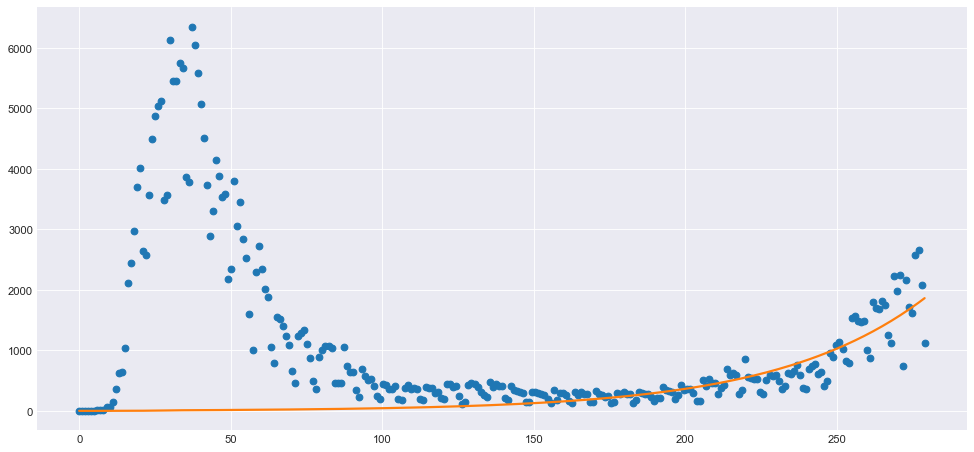

In [572]:
final = inf_dead[:,0] + result.residual.reshape(inf_dead[:,0].shape)
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, inf_dead[:,0], 'o')
plt.plot(t, final, '-', linewidth=2)
plt.show()

In [66]:
Proporcao de assintomaticos: 2.8%
taxa de mortalidade: 1.39% (março-junho)
taxa de infeccao: 17.2% (março-junho)

SyntaxError: invalid syntax (<ipython-input-66-5b116aeee937>, line 1)

In [147]:
report_fit(result)

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 378
    # data points      = 279
    # variables        = 17
    chi-square         = 8.5739e+08
    reduced chi-square = 3272462.14
    Akaike info crit   = 4201.75387
    Bayesian info crit = 4263.48447
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    E:       5.4456e-09 (fixed)
    Eq:      4.868e-09 (fixed)
    R:       0 (fixed)
    A:       0 (fixed)
    Aq:      0 (fixed)
    Q:       0 (fixed)
    D:       0 (fixed)
    I:       7.2747e-09 (fixed)
    Iq:      2.9265e-09 (fixed)
    tau:     0.16584206 (init = 0.1658421)
    sigma:   0.70116841 (init = 0.7011684)
    alpha:   0.46800622 (init = 0.4680062)
    lambd1:  0.01000000 (init = 0.01)
    lambd2:  0.1

In [558]:
t = np.arange(0,278)
x0 = np.array([10e-6,0,0,0,0,0,0,0,0])

tau = 0.16584206
sigma = 0.70116841
alpha = 0.46800622
lambd1 = 8.7054e-04
lambd2 = 0.14662076
mu = 0.32584105
mu2 = 0.1012661
tmu = 60
delta = 1
beta = 0.64846010
r = 0.50337656
rho = 1.1392e-04
irho = 0.13904760
p = 0.74907787
p2 = 0.74907787
tp = 30
prob = 0.1



t_params = np.array((tau, sigma, alpha, lambd1, lambd2, mu, mu2, tmu, delta, beta, r, rho, irho, p, p2, tp, prob))

In [559]:
sol = g(t,x0,t_params)

150.35952967592988
150.35952967592988
150.35952967592988
150.35952967592988
150.35952967592988
150.35952967592988
150.35952967592988
150.35952967592988
150.35952967592988
150.35952967592988
150.35952967592988
150.35952967592988
150.35952967592988
150.35952967592988
150.35952967592988
150.35952967592988
150.35952967592988
150.35952967592988


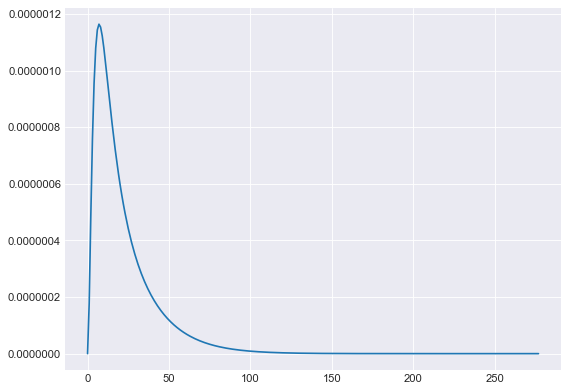

In [563]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(sol[:,5])

In [472]:
t = np.arange(0,278)

In [682]:
residual(result.params,t,inf_dead[:100]))

name,value,initial value,min,max,vary
E,0.00000000,0,0.00000000,1.00000000,False
R,0.00000000,0.0,0.00000000,1.00000000,False
A,0.00000000,0.0,0.00000000,1.00000000,False
H,0.00000000,0.0,0.00000000,1.00000000,False
D,0.00000000,0.0,0.00000000,1.00000000,False
I,10.0000000,10,0.00000000,10.0000000,False
beta,0.35182565,0.303,0.01000000,0.80000000,True
beta2,0.20571113,0.103,0.01000000,0.80000000,True
la,0.79943390,0.851,0.01000000,1.00000000,True
la2,0.83170400,0.851,0.01000000,1.00000000,True


In [467]:
np.concatenate?

In [836]:
#contruimos nosso modelo f especificando o sistema de edos
def f(xs,t,ps):
    
    # Esse try é conveniente para mais tarde passar um dicionario dos parametros para
    # poder fazer o fitting do modelo aos dados com o biblioteca lmfit
    
    #para mais detalhes dos parametros olhar o .pdf dos resultados finais
    try:
        beta =ps['beta'].value
        beta2 =ps['beta2'].value
        la = ps['la'].value
        la2 = ps['la2'].value
        l = ps['l'].value
        l2 = ps['l2'].value
        k =ps['k'].value
        p = ps['p'].value
        lamba = ps['lamba'].value
        lambi =ps['lambi'].value
        lambr =ps['lambr'].value
        mu =ps['mu'].value
        mu2 =ps['mu2'].value
        deltaa =ps['deltaa'].value
        deltah =ps['deltah'].value
        deltai =ps['deltai'].value 
        T = ps['T'].value

    except:
        
        beta, beta2, la, la2, l, l2, k, p, lamba, lambi, lambr, mu,mu2, deltaa, deltah, deltai, T = ps
        
    
    #inicializando os valores dos estados do nosso sistema
    
    S,E,I,A,H,R,D = xs
    
    N = np.sum(xs)
    
    if t>T:
        beta = beta2
        l = l2
        la = la2
        mu = mu2

    return [
        -S*beta*(I+la*A+l*H)/N,
        S*beta*(I+la*A+l*H)/N - k*E,
        k*p*E-(lamba+lambi+deltai)*I,
        k*(1-p)*E-mu*A,
        lamba*I-(lambr+deltah)*H,
        lambi*I+lambr*H+mu*(1+deltaa)*A,
        deltah*H+deltai*I+mu*deltaa*A
           ]

# funcao g ira tratar valores iniciais para que a soma deles somam 1 e devolve a solucao 
# numerica do nosso modelo dado tempo, condicoes inicais e parametros
def g(t, x0, ps):
    
    N = 8*10e5
    S = N - np.sum(x0)
    x0 = np.insert(x0,0,S)
    
    x = odeint(f,x0, t, args = (ps,))
    
    return x


#funcao residual é usada mais tarde pela biblioteca lmfit para fittar o modelo aos dados
def residual(ps, ts, data):
    x0 = ps['E'].value,ps['I'].value,ps['A'].value,ps['H'].value,ps['R'].value,ps['D'].value
    model = g(ts, x0, ps)
    model = model[:,[2,4,6]]
    
    
    return (model - data).ravel()



In [816]:
def residual(ps, ts, data):
    x0 = ps['E'].value,ps['I'].value,ps['A'].value,ps['H'].value,ps['R'].value,ps['D'].value
    model = g(ts, x0, ps)
    model = model[:,[2,6]]
    
    
    return (model - data).ravel()

In [837]:
t = np.linspace(0,279,279)
x0 = [0,1,0,0,0,0]
pparms = (0.303,0.103, 0.851,0.851,4.090,0.820,1.33,1.01,0.055,0.296,0.018,0.0828,0.0828,0,0.00029,0.023,51)

beta,beta2,l,l2,la,la2,k,p,lamba,lambi,lambr,mu,mu2,deltaa,deltah,deltai,T = pparms

sol = g(t,x0, pparms)

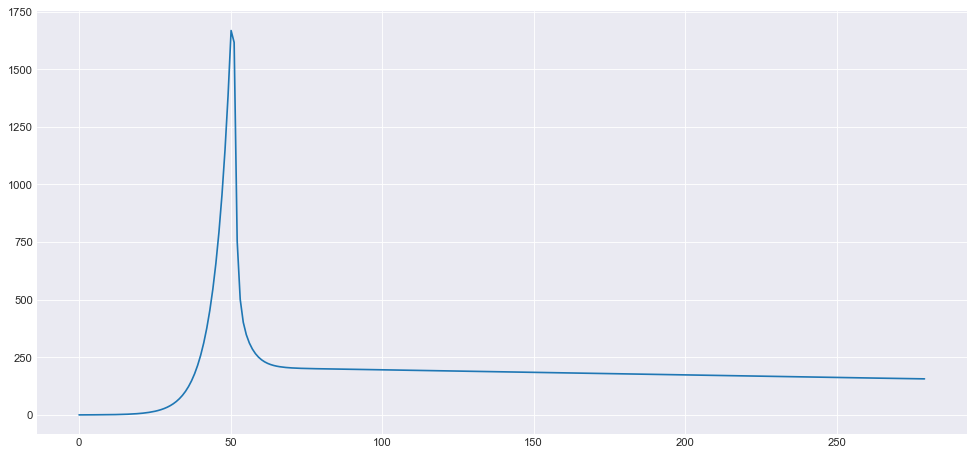

In [789]:
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, sol[:,1])
plt.show()

In [819]:
df

,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
0,1,0,0
1,0,0,0
2,0,0,0
3,1,1,0
4,5,2,0
...,...,...,...
274,1622,133,11
275,2580,152,17
276,2665,157,17
277,2087,125,22


In [838]:
params = Parameters()

#adicionando todos parametros necessarios para rodar o modelo

#tratamos as condiçoes inicias como parametros tb
params.add('E', value=0, min=0, max=1,vary= False)
params.add('R', value=0.0, min=0, max=1, vary= False)
params.add('A', value=0.0, min=0, max=1, vary= False)
params.add('H', value=0.0, min=0, max=1, vary= False)
params.add('D', value=0.0, min=0, max=1, vary= False)
params.add('I', value=10, min=0, max=10, vary= False)


#parametros do modelo
params.add('beta', value=0.303, min=0.01, max=0.8, vary = True)
params.add('beta2', value=0.103, min=0.01, max=0.8, vary =True)
params.add('la', value=0.851, min=0.01, max=1, vary = True)
params.add('la2', value=0.851, min=0.01, max=1, vary = True)
params.add('l', value=4.090, min=0.01, max=5, vary = True)
params.add('l2', value=0.820, min=0.01, max=1, vary = True)
params.add('k', value=1.33, min=0.01, max=2, vary = True)
params.add('p', value=1.010, min=0, max=2, vary = True)
params.add('lamba', value=0.055, min=0, max=1, vary = True)
params.add('lambi', value=0.296, min=0, max=1, vary = True)
params.add('lambr', value=0.018, min=0, max=1, vary = True)
params.add('mu', value=0.0828, min=0, max=1, vary = True)
params.add('mu2', value=0.0828, min=0, max=1, vary = False)
params.add('deltaa', value=0, min=0, max=1, vary = False)
params.add('deltah', value=0.00029, min=0, max=1, vary = True)
params.add('deltai', value=0.023, min=0, max=1)
params.add('T', value=51, min=0, max=100)



result1 = minimize(residual, params, args = (t[:120],inf_dead[:120]), method= 'L-BFGS-B')


result2 = minimize(residual, params, args = (t[180:],inf_dead[180:]), method= 'L-BFGS-B')


In [841]:
final1 = inf_dead[:120] + result1.residual.reshape(inf_dead[:120].shape)
final2 = inf_dead[180:] + result2.residual.reshape(inf_dead[180:].shape)


final = np.concatenate((final1,np.zeros((60,3)),final2))

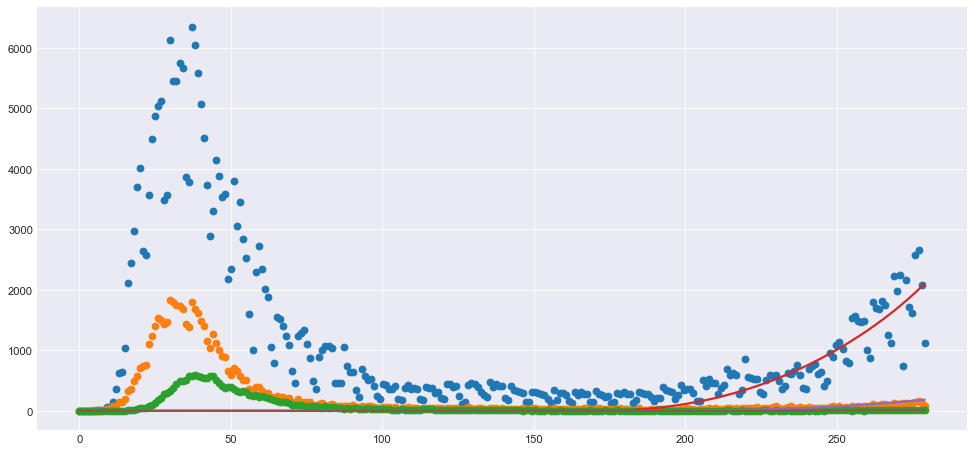

In [847]:
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, inf_dead, 'o')
plt.plot(t, final, '-', linewidth=2)
plt.show()

In [843]:
report_fit(result1)

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 48
    # data points      = 360
    # variables        = 15
    chi-square         = 8.2276e+08
    reduced chi-square = 2384821.40
    Akaike info crit   = 5301.14707
    Bayesian info crit = 5359.43863
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    E:       0 (fixed)
    R:       0 (fixed)
    A:       0 (fixed)
    H:       0 (fixed)
    D:       0 (fixed)
    I:       10 (fixed)
    beta:    0.15174011 (init = 0.303)
    beta2:   0.08804722 (init = 0.103)
    la:      0.86549674 (init = 0.851)
    la2:     0.85106170 (init = 0.851)
    l:       3.96027615 (init = 4.09)
    l2:      0.81738603 (init = 0.82)
    k:       1.33086357 (init = 1.33)
    p:       0.97

In [784]:
report_fit(result2)

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 2688
    # data points      = 297
    # variables        = 15
    chi-square         = 9259949.27
    reduced chi-square = 32836.6996
    Akaike info crit   = 3103.20067
    Bayesian info crit = 3158.60665
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    E:       0 (fixed)
    R:       0 (fixed)
    A:       0 (fixed)
    H:       0 (fixed)
    D:       0 (fixed)
    I:       10 (fixed)
    beta:    0.30300000 (init = 0.303)
    beta2:   0.30081345 (init = 0.103)
    la:      0.85100000 (init = 0.851)
    la2:     0.85363832 (init = 0.851)
    l:       4.09000000 (init = 4.09)
    l2:      0.86873782 (init = 0.82)
    k:       1.38235255 (init = 1.33)
    p:       1.

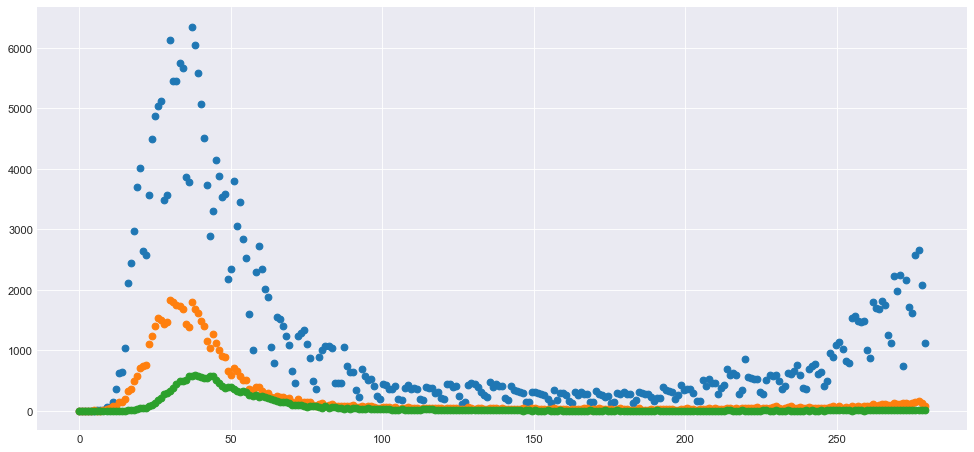

In [772]:
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, inf_dead, 'o')
plt.show()

In [769]:
df

,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
0,1,0,0
1,0,0,0
2,0,0,0
3,1,1,0
4,5,2,0
...,...,...,...
274,1622,133,11
275,2580,152,17
276,2665,157,17
277,2087,125,22


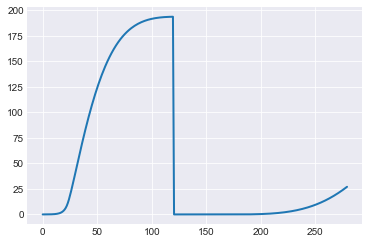

In [748]:
plt.plot(t, final[:,2], '-', linewidth=2)

In [803]:
params = Parameters()

#adicionando todos parametros necessarios para rodar o modelo

#tratamos as condiçoes inicias como parametros tb
params.add('E', value=0, min=0, max=1,vary= False)
params.add('R', value=0.0, min=0, max=1, vary= False)
params.add('A', value=0.0, min=0, max=1, vary= False)
params.add('H', value=0.0, min=0, max=1, vary= False)
params.add('D', value=0.0, min=0, max=1, vary= False)
params.add('I', value=10, min=0, max=10, vary= False)


#parametros do modelo
params.add('beta', value=0.303, min=0.01, max=0.8, vary = True)
params.add('beta2', value=0.103, min=0.01, max=0.8, vary =True)
params.add('la', value=0.851, min=0.01, max=1, vary = True)
params.add('la2', value=0.851, min=0.01, max=1, vary = True)
params.add('l', value=4.090, min=0.01, max=5, vary = True)
params.add('l2', value=0.820, min=0.01, max=1, vary = True)
params.add('k', value=1.33, min=0.01, max=2, vary = True)
params.add('p', value=1.010, min=0, max=2, vary = True)
params.add('lamba', value=0.055, min=0, max=1, vary = True)
params.add('lambi', value=0.296, min=0, max=1, vary = True)
params.add('lambr', value=0.018, min=0, max=1, vary = True)
params.add('mu', value=0.0828, min=0, max=0.5, vary = True)
params.add('mu2', value=0.0828, min=0, max=0.5, vary = True)
params.add('deltaa', value=0, min=0, max=1, vary = False)
params.add('deltah', value=0.00029, min=0, max=1, vary = True)
params.add('deltai', value=0.023, min=0, max=1)
params.add('T', value=51, min=0, max=100)



result1 = minimize(residual, params, args = (t[:70],inf_dead[:70,2]), method= 'L-BFGS-B')

#params.add('D', value=1.93539042e+02, min=0, max=1.93539042e+02, vary= False)

#result2 = minimize(residual, params, args = (t[180:],inf_dead[180:]), method= 'L-BFGS-B')

final1 = inf_dead[:70,2] + result1.residual.reshape(inf_dead[:70,2].shape)
#final2 = inf_dead[180:] + result2.residual.reshape(inf_dead[180:].shape)


#final = np.concatenate((final1,np.zeros((60,3)),final2))

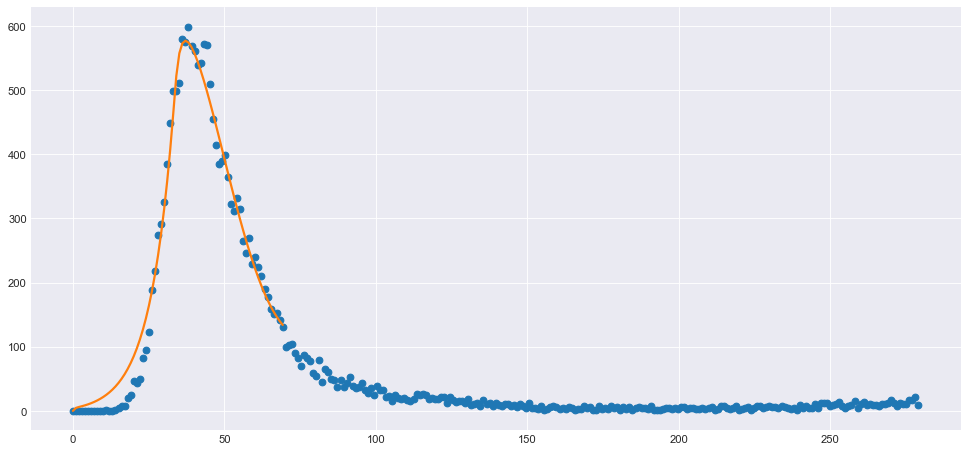

In [804]:
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, inf_dead[:,2], 'o')
plt.plot(t[:70], final1, '-', linewidth=2)
plt.show()

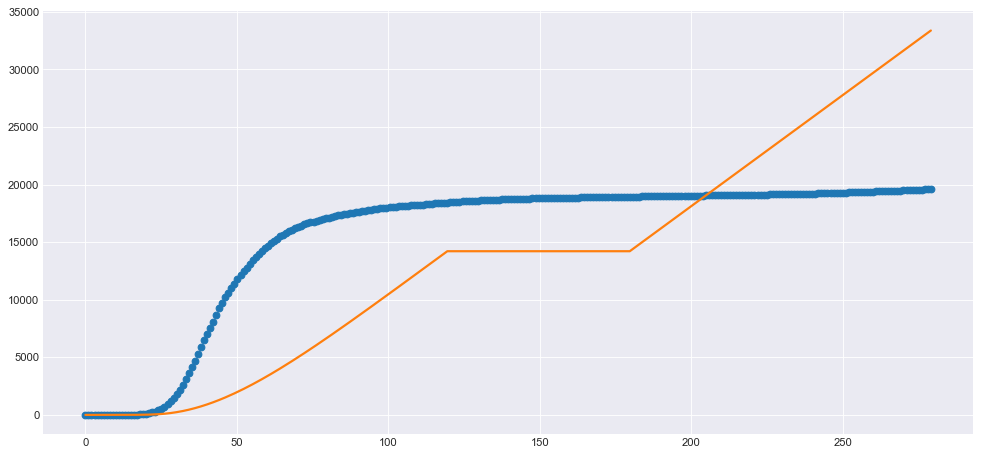

In [768]:
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, inf_dead[:,2].cumsum(), 'o')
plt.plot(t, final[:,2].cumsum(), '-', linewidth=2)
plt.show()

In [806]:
mmres = result1

In [808]:
mmres.params

name,value,initial value,min,max,vary
E,0.00000000,0,0.00000000,1.00000000,False
R,0.00000000,0.0,0.00000000,1.00000000,False
A,0.00000000,0.0,0.00000000,1.00000000,False
H,0.00000000,0.0,0.00000000,1.00000000,False
D,0.00000000,0.0,0.00000000,1.00000000,False
I,10.0000000,10,0.00000000,10.0000000,False
beta,0.14628550,0.303,0.01000000,0.80000000,True
beta2,0.45319886,0.103,0.01000000,0.80000000,True
la,0.74552125,0.851,0.01000000,1.00000000,True
la2,0.88794011,0.851,0.01000000,1.00000000,True


In [810]:
params = mmres.params


result1 = minimize(residual, params, args = (t[:120],inf_dead[:120]), method= 'L-BFGS-B')

In [811]:
final1 = inf_dead[:120] + result1.residual.reshape(inf_dead[:120].shape)

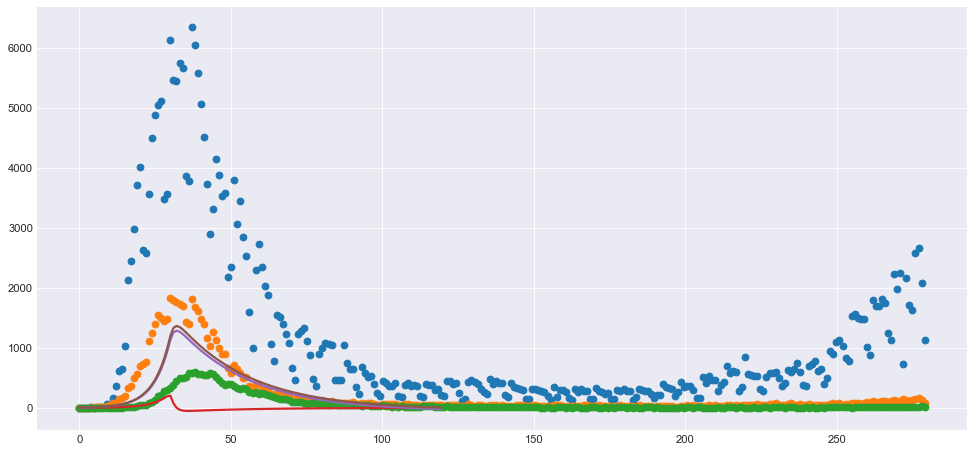

In [815]:
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, inf_dead, 'o')
plt.plot(t[:120], final1, '-', linewidth=2)
plt.show()